In [1]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')

Using TensorFlow backend.


In [2]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt

img_path = '/home/alex/下载/学习/python/convnet/filters/eager.jpg'

img = image.load_img(img_path, target_size=(224,224))

plt.imshow(img)
plt.show()

<Figure size 640x480 with 1 Axes>

In [3]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

predicts = model.predict(x)

In [4]:
print(decode_predictions(predicts, top=3)[0])

[('n01614925', 'bald_eagle', 0.9991105), ('n01608432', 'kite', 0.0008125829), ('n01616318', 'vulture', 6.090444e-05)]


In [5]:
np.argmax(predicts[0])

22

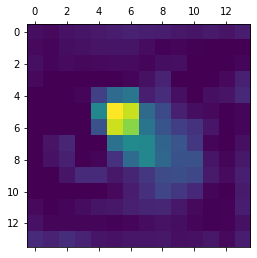

In [6]:
from keras import backend as K

code = np.argmax(predicts[0])

tiger_output = model.output[:,code]

last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(tiger_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0,1,2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis = -1)


heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

plt.savefig('heatmap.png')

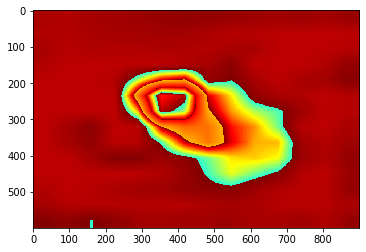

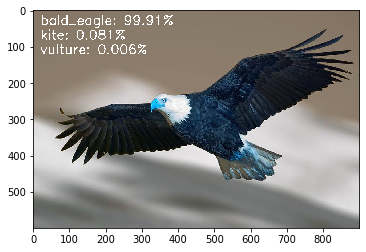

In [8]:
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

plt.imshow(heatmap)
plt.show()

font = cv2.FONT_HERSHEY_SIMPLEX
text_tuple_list = decode_predictions(predicts, top=3)[0]

def sort_list(elem):
    return elem[2]

text_tuple_list.sort(key=sort_list, reverse=True)
for key, value in enumerate(text_tuple_list):
    y = 40 * (key + 1)
    txt = str(value[1]) + ': ' + str(value[2] * 100)[:5] + '%'
    cv2.putText(img, txt, (20, y), font, 1.2, (255, 255, 255), 2)

plt.imshow(img)
plt.savefig('img.png')
plt.show()

for i in range(10):
    superimposed_img = heatmap * 0.1 * (i + 1) + img
    cv2.imwrite('/home/alex/下载/学习/python/convnet/filters/cam_{}.jpg'.format(i + 1), superimposed_img)
    
